In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skbio.stats.composition import clr
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
import os
import sys

os.chdir('/home/alexis/UAM/picrust/DataSets')

In [5]:
pathway_unstrat = load_unstrat_pathway(path = 'pathways_out/path_abun_unstrat.tsv.gz')

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


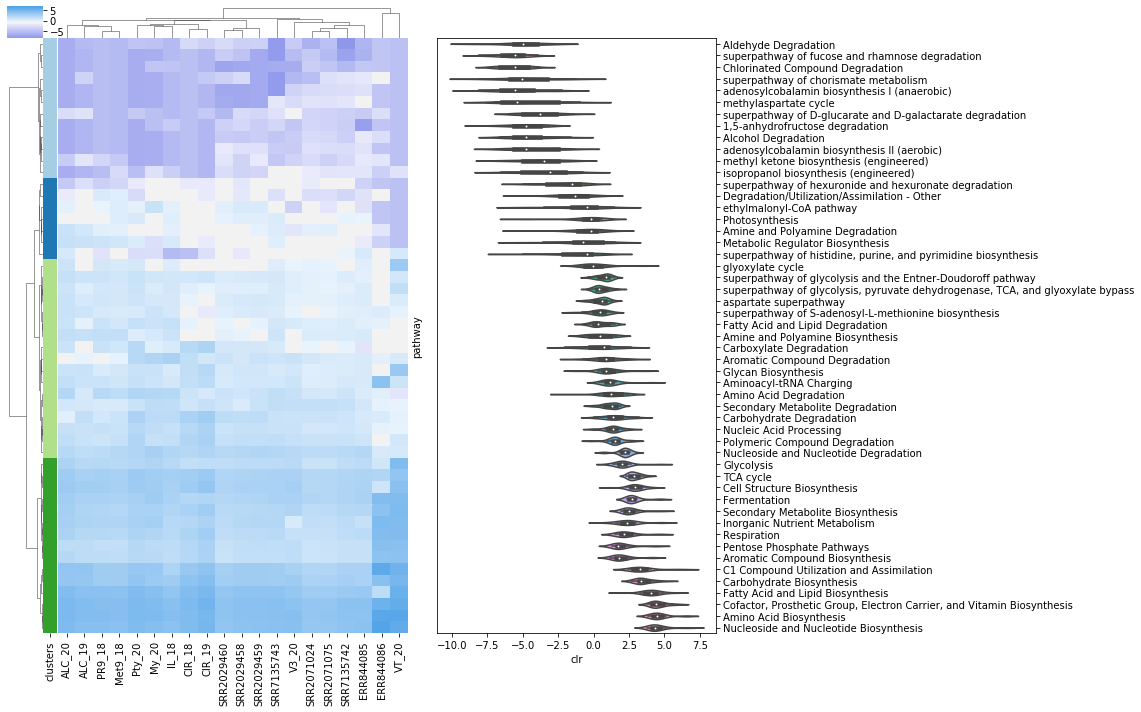

In [7]:
fig = heat_map_violin_plot(pathway_unstrat['second_level_clr'])
fig.savefig('Analysis/pthwy_heatmap.png')

In [9]:
pathway_unstrat['bottom_level_C'].transpose().to_csv('/home/alexis/UAM/banocc/DataSets/composition.csv', sep = '\t', index = False, header = False)

In [4]:
def load_taxonomy(path = '/home/alexis/UAM/qiime/Mar20/OTUs_95/silva_taxonomy.csv'):
    taxonomy = pd.read_csv(path, sep = '\t')
    taxonomy.set_index('sequence_identifier', inplace = True)
    taxonomy.fillna('unknown', inplace = True)
    for tax in taxonomy.loc[:,'Genus'].unique():
        tax_filter = taxonomy.loc[:,'Genus'] == tax
        n = 0
        for i in taxonomy.loc[tax_filter].index:
            taxonomy.loc[i, 'Genus'] = taxonomy.loc[i, 'Genus']+str(n)
            n+=1
    return taxonomy

def load_strat_pathway(taxonomy_df, pathways_path = 'pathways_out/path_abun_contrib.tsv.gz', abundance_path = '/home/alexis/UAM/qiime/Mar20/OTUs_95/otu-table-16Sgenecount-corrected.tsv'):
    pathways_strat_df = pd.read_csv(pathways_path, compression = 'gzip', sep = '\t')
    abundance_df = pd.read_csv(abundance_path, sep = '\t')
    abundance_df.set_index('OTU_ID', inplace = True)
    
    for sample in abundance_df.columns:
        abundance_df.loc[:, sample] = abundance_df.loc[:, sample]/abundance_df.loc[:, sample].sum()
        sample_filter = pathways_strat_df.loc[:,'sample'] == sample
        for tax in pathways_strat_df.loc[sample_filter, 'taxon'].unique():
            tax_filter = pathways_strat_df.loc[:, 'taxon'] == tax
            full_filter =(sample_filter*1 == 1) & (tax_filter*1 == 1)
            pathways_strat_df.loc[full_filter, 'taxon_rel_abun'] = abundance_df.loc[tax, sample]       
    
    pathways_strat_df.loc[:,'taxon_rel_function_abun'] = pathways_strat_df.loc[:, 'taxon_rel_abun']*pathways_strat_df.loc[:,'genome_function_count']
    zero_filter = pathways_strat_df['taxon_rel_function_abun'] == 0
    for entryid in pathways_strat_df.loc[zero_filter, :].index:
        pathways_strat_df.loc[entryid, 'taxon_rel_function_abun'] = pathways_strat_df.loc[entryid, 'taxon_rel_abun']*pathways_strat_df.loc[entryid, 'genome_function_count']
    
    for tax in taxonomy_df.index:
        tax_filter = pathways_strat_df.loc[:,'taxon'] == tax
        pathways_strat_df.loc[tax_filter, 'taxon'] = taxonomy_df.loc[tax, 'Genus']
        
    return pathways_strat_df, abundance_df
        

def load_unstrat_pathway(path = 'pathways_out/path_abun_unstrat.tsv.gz', default_path = '/home/alexis/UAM/picrust/default_files/'):
    #Load pathway abundance by sample
    pthwy_df = pd.read_csv(path, compression = 'gzip', sep = '\t')
    pthwy_df.set_index('pathway', inplace = True)
    
    pathway_unstrat = {}
    #Load bottom level description
    bottom_level = pd.read_csv(default_path+'metacyc_pathways_info.txt.gz', compression = 'gzip', sep = '\t', names = ['pathway', 'description'])
    bottom_level.set_index('pathway', inplace = True)
    #Load second level description
    second_level = pd.read_csv(default_path+'metacyc_pathways_info_prokaryotes_sec_level.tsv', sep = '\t', names = ['pathway', 'description'])
    second_level.set_index('pathway', inplace = True)
    
    #Annotate bottom level pathways
    pathway_unstrat['bottom_level'] =  pthwy_df.join(bottom_level)
    pathway_unstrat['bottom_level'].set_index('description', inplace = True)
    #Calculate centered log-ratio
    pathway_unstrat['bottom_level_clr'] = pathway_unstrat['bottom_level'].copy()
    pathway_unstrat['bottom_level_C'] = pathway_unstrat['bottom_level'].copy()
    pathway_unstrat['bottom_level_clr'].loc[:,:] = pathway_unstrat['bottom_level_clr'].loc[:,:] + 0.00001
    
    for sample in pathway_unstrat['bottom_level_clr'].columns:
        pathway_unstrat['bottom_level_clr'].loc[:,sample] = clr(pathway_unstrat['bottom_level_clr'].loc[:,sample])
        pathway_unstrat['bottom_level_C'].loc[:,sample] = pathway_unstrat['bottom_level_C'].loc[:,sample]/pathway_unstrat['bottom_level_C'].loc[:,sample].sum()
        
    pathway_unstrat['bottom_level_clr'].index.name = 'pathway'
    pathway_unstrat['bottom_level'].index.name = 'pathway'
    pathway_unstrat['bottom_level_C'].index.name = 'pathway'
    
    #Annotate second level pathways
    temp_2ndlvl = pthwy_df.join(second_level)
    #Sum pathways with the same second level annotation
    pathway_unstrat['second_level'] = pd.DataFrame(index = temp_2ndlvl.loc[:,'description'].unique(), columns = pathway_unstrat['bottom_level'].columns, dtype = 'float64')
    for pathway in pathway_unstrat['second_level'].index:
        path_filter = temp_2ndlvl.loc[:, 'description'] == pathway 
        for sample in pathway_unstrat['second_level'].columns:
            pathway_unstrat['second_level'].loc[pathway, sample] = temp_2ndlvl.loc[path_filter, sample].sum()
    #Calculate centered log-ratio of second level pathways
    
    pathway_unstrat['second_level_clr'] = pathway_unstrat['second_level'].copy()
    pathway_unstrat['second_level_C'] = pathway_unstrat['second_level'].copy()
    pathway_unstrat['second_level_clr'].loc[:,:] = pathway_unstrat['second_level_clr'].loc[:,:] + 10
    for sample in pathway_unstrat['second_level_clr'].columns:
        pathway_unstrat['second_level_clr'].loc[:,sample] = clr(pathway_unstrat['second_level_clr'].loc[:,sample])   
        pathway_unstrat['second_level_C'].loc[:,sample] = pathway_unstrat['second_level_C'].loc[:,sample]/pathway_unstrat['second_level_C'].loc[:,sample].sum()
    
    pathway_unstrat['second_level_clr'].index.name = 'pathway'
    pathway_unstrat['second_level'].index.name = 'pathway'
    pathway_unstrat['second_level_C'].index.name = 'pathway'
    return pathway_unstrat

def heat_map_violin_plot(pthwy_df):
    row_linkage = linkage(pdist(pthwy_df.to_numpy()), method = "ward", optimal_ordering = True)
    row_cluster = fcluster(row_linkage, 4, criterion = 'maxclust')
    fun_palette = dict(zip(np.unique(row_cluster), 
                           sns.color_palette("Paired", len(np.unique(row_cluster)))))
    fun_color = pd.Series(row_cluster, 
                          index = pthwy_df.index, name = 'clusters').map(fun_palette)
    row_color = pd.DataFrame(fun_color)

    col_linkage = linkage(pdist(pthwy_df.T.to_numpy()), 
                          method = "weighted", optimal_ordering = True)

    cmap = sns.diverging_palette(263, 244, s = 79, l = 65, sep = 20, as_cmap = True)
    fig_heatmap = sns.clustermap(pthwy_df, row_linkage = row_linkage, 
                                     col_linkage = col_linkage, cmap = cmap, 
                                     method = "weighted",
                                     row_colors = row_color, dendrogram_ratio=0.05, 
                                     colors_ratio=0.02, yticklabels = True)
    temp1 = pthwy_df.copy()
    temp1.reset_index(inplace = True)
    temp = pd.melt(temp1.reset_index(), id_vars = ['pathway'], value_vars = pthwy_df.columns, var_name = 'sample', value_name = 'clr')

    # make some space to the right in the figure
    fig_heatmap.gs.update(right=1)
    # divide existing axes
    divider = make_axes_locatable(fig_heatmap.ax_heatmap)
    divider2 = make_axes_locatable(fig_heatmap.ax_col_dendrogram)
    # create new axes for bar plot 
    vlplt_ax = divider.append_axes("right", size="80%", pad=0.4)
    # create empty space of same size as bar plot axes (don't use this space)
    vlplt_nax = divider2.new_horizontal(size="80%", pad=0.4)

    #Draw a violin plot of clr's for each pathway
    vlplt_order = [t.get_text() for t in np.array(fig_heatmap.ax_heatmap.get_yticklabels())]
    sns.violinplot(y = 'pathway', x = 'clr', data = temp, ax = vlplt_ax, order = vlplt_order)
    #Move labes to the rigth
    vlplt_ax.yaxis.set_ticks_position('right')
    vlplt_ax.yaxis.label.set_visible(False)
    #turn off labels of the heatmap
    fig_heatmap.ax_heatmap.set_yticklabels('')
    fig_heatmap.ax_heatmap.set_yticks([])
    return fig_heatmap


def sample_strat_pathway(sample, pthwy_df):
    #Load bottom level description
    bottom_level = pd.read_csv('default_file/metacyc_pathways_info.txt.gz', compression = 'gzip', sep = '\t', names = ['pathway', 'description'])
    bottom_level.set_index('pathway', inplace = True)

    #Load second level description
    second_level = pd.read_csv('default_file/metacyc_pathways_info_prokaryotes_sec_level.tsv', sep = '\t', names = ['pathway', 'description'])
    second_level.set_index('pathway', inplace = True)

    sample_strat = {}
    sample_filter = pthwy_df.loc[:,'sample'] == sample
    pthwy_df = pthwy_df.loc[sample_filter,:]

    #for that we construct a tax_func_relabun_matrix where rows will be functions and columns will be taxons
    taxons = pthwy_df['taxon'].unique()
    functions = pthwy_df['function'].unique()
    sample_strat['bottom_level'] = pd.DataFrame( index = functions, columns = taxons)

    #iterate over all taxons
    for taxid in taxons:
        #Create a dataset with the information of all functions but only one taxon
        tax_filter = pthwy_df.loc[:,'taxon'] == taxid
        temp_df = pthwy_df.loc[tax_filter, ['function', 'taxon_rel_function_abun']]
        temp_df.set_index('function', inplace = True)
        #iterate for all functions to which taxonid contributes
        for funid in temp_df.index:
            #replace the entry for funid in relabun_matrix with taxon_rel_function_abun of the filtered datased for said funid
            sample_strat['bottom_level'].loc[funid, taxid] = temp_df.loc[funid, 'taxon_rel_function_abun']
        #delete the filtered dataset
        del temp_df

    #Apply centered log-ratio over each function
    sample_strat['bottom_level'].fillna(sample_strat['bottom_level'].loc[:,:].min().min()/2, inplace = True)
    sample_strat['bottom_level'].loc[:,:] = sample_strat['bottom_level'].loc[:,:] + sample_strat['bottom_level'].loc[:,:].min().min()

    sample_strat['bottom_level_clr'] = sample_strat['bottom_level'].copy()
    for funid in sample_strat['bottom_level_clr'].index:
        sample_strat['bottom_level_clr'].loc[funid, :] = clr(sample_strat['bottom_level_clr'].loc[funid, :])

    #Annotate second level pathways
    temp_2ndlvl = sample_strat['bottom_level'].copy()
    temp_2ndlvl = temp_2ndlvl.join(second_level)
    #Sum pathways with the same second level annotation
    sample_strat['second_level'] = pd.DataFrame(index = temp_2ndlvl.loc[:,'description'].unique(), columns = sample_strat['bottom_level'].columns, dtype = 'float64')
    for pathway in sample_strat['second_level'].index:
        path_filter = temp_2ndlvl.loc[:, 'description'] == pathway 
        for tax in sample_strat['second_level'].columns:
            sample_strat['second_level'].loc[pathway, tax] = temp_2ndlvl.loc[path_filter, tax].sum()

    sample_strat['second_level_clr'] = sample_strat['second_level'].copy()
    for funid in sample_strat['second_level_clr'].index:
        sample_strat['second_level_clr'].loc[funid, :] = clr(sample_strat['second_level_clr'].loc[funid, :])
    sample_strat['second_level_clr'].index.name = 'pathway'
    
    return sample_strat

def heatmap_pathway_plot(pathwy_df, taxonomy_df):
    filt = [0]*taxonomy_df.shape[0]
    for tax in pathwy_df['bottom_level_clr'].columns:
        filt = filt + (taxonomy_df.loc[:,'Genus'] == tax)*1
    filt = filt == 1 

    taxonomy_filtered = taxonomy_df[filt].copy()
    row_linkage = linkage(pdist(pathwy_df['bottom_level_clr'].to_numpy()), method = "ward", optimal_ordering = True)
    row_cluster = fcluster(row_linkage, 6, criterion = 'maxclust')
    fun_palette = dict(zip(np.unique(row_cluster), 
                           sns.color_palette("Paired", len(np.unique(row_cluster)))))
    fun_color = pd.Series(row_cluster, 
                          index = pathwy_df['bottom_level_clr'].index, name = 'clusters').map(fun_palette)
    row_color = pd.DataFrame(fun_color)
    col_linkage = linkage(pdist(pathwy_df['bottom_level_clr'].T.to_numpy()), 
                          method = "weighted", optimal_ordering = True)

    #Well display what taxonomic class and order each taxon belongs to
    #Create a dictionary of unique orders and the assigned color
    ord_palette = dict(zip(taxonomy_filtered['Order'].unique(), 
                           sns.color_palette("Set2", len(taxonomy_filtered['Order'].unique()))))

    #map the dictionary to a series containg the taxons (as index) and the order of each taxon
    ord_color = pd.Series(taxonomy_filtered.loc[:, 'Order'].to_numpy(), 
                          index = taxonomy_filtered['Genus'], name = 'order').map(ord_palette)

    #Create a dictionary of unique classes and the assigned color
    cls_palette = dict(zip(taxonomy_filtered['Class'].unique(), 
                           sns.color_palette("Set3", len(taxonomy_filtered['Class'].unique()))))

    #map the dictionary to a series containg the taxons (as index) and the classes of each taxon
    cls_color = pd.Series(taxonomy_filtered.loc[:, 'Class'].to_numpy(), 
                          index = taxonomy_filtered['Genus'], name = 'Class').map(cls_palette)

    #Join both color maps as a dataframe
    col_color = pd.DataFrame(ord_color).join(pd.DataFrame(cls_color))

    #create a divergent colormap since the data is symmetric
    cmap2 = sns.diverging_palette(263, 244, s = 79, l = 65, sep = 20, as_cmap = True)
    #draw the clustered heatmap of the clr-transformed relative contributions of each taxon to each function
    fig_clr_heatmap = sns.clustermap(pathwy_df['bottom_level_clr'], row_linkage = row_linkage, 
                                     col_linkage = col_linkage, cmap = cmap2, 
                                     cbar_kws = {'orientation':'horizontal', 'label':'centered log-ratio taxon contribution'}, 
                                     cbar_pos=(0.2, 1.01, 0.66, 0.02), method = "weighted", col_colors = col_color, 
                                     row_colors = row_color, dendrogram_ratio=0.075, colors_ratio=0.02, yticklabels = False)

    fig_clr_heatmap.ax_heatmap.set_ylabel("Pathways", fontsize = "xx-large")
    fig_clr_heatmap.cax.tick_params(labelsize = 11, top = True, labeltop = True, bottom = False, 
                                    labelbottom = False, width = 2, length = 5)
    fig_clr_heatmap.cax.xaxis.label.set_size(14)
    fig_clr_heatmap.savefig("clr-contribution.png")

    for label in taxonomy_filtered['Class'].unique():
        fig_clr_heatmap.ax_col_dendrogram.bar(0, 0, color=cls_palette[label], label=label, linewidth=0)
    l1 = fig_clr_heatmap.ax_col_dendrogram.legend(title='class', loc="upper left", ncol=1, bbox_to_anchor=(1.02, -0.5))

    for label in taxonomy_filtered['Order'].unique():
        fig_clr_heatmap.ax_row_dendrogram.bar(0, 0, color=ord_palette[label], label=label, linewidth=0)
    l2 = fig_clr_heatmap.ax_row_dendrogram.legend(title='order', loc="upper left", ncol=1, bbox_to_anchor=(13.6, 0.3))
    
    return fig_clr_heatmap

In [4]:
import pystan
import pickle
from stan_utility import utils as su
import arviz as az
import numpy as np
import pandas as pd

def run_banocc(C, file = 'BAnOCC.pkl', a = 0.5, b = 0.01, chains = 4, 
               iters = 50, n_jobs = 4, thin = 1, init = [], control = []):
    
    warmup = int(np.floor(iters/2))
    
    if not isinstance(C, np.ndarray):
        print('Converted C to numpy')
        C = C.to_numpy()
    
    print('Checking C')
    check_c(C)
    banocc = pickle.load(open(file, 'rb'))
    
    n = 0*np.ones(C.shape[1])
    L = np.diag(10*np.ones(C.shape[1]))
    data = {'C':C, 'n':n, 'L':L, 'a':a, 'b':b, 'N':C.shape[0], 'P':C.shape[1]}
    if not init:
        init = [get_init(data) for b in range(chains)]
        print('Startet model fitting')
        fit = banocc.sampling(data = data, chains = chains, iter = iters, n_jobs = 4, 
                               warmup = warmup, thin = thin, refresh = np.floor(iters/20))
     
    su.check_treedepth(fit)
    su.check_energy(fit)
    su.check_div(fit)
    return fit

def get_init(data):
    init = {'m':np.random.multivariate_normal(data['n'], data['L']),
           'O':np.diag(1*np.ones(data['P'])),
           'lamb':np.random.gamma(data['a'], data['b'])}
    
    return init
    
    
class SampleError(Exception):
    def __init__(self, value):
         self.value = value
    def __str__(self):
         return repr(self.value)
        
class CompositionError(Exception):
    def __init__(self, value):
         self.value = value
    def __str__(self):
         return repr(self.value)
        
def check_c(C):
    try:
        if np.any((C.sum(axis = 1) - 1) > 1e-8):
            raise SampleError('Composition for some samples does not sum to 1')
        if np.any((1 - C.sum(axis = 1)) > 1e-8):
            raise CompositionError('Composition for some samples sums to less than 1')
    except SampleError:
        raise
    except CompositionError:
        raise
    